## Processes PPMI methylation data to a dataframe    

### DO NOT RUN, NEEDS A DATA FILE  TO BIG FOR GITHUB 8 GB

### Summary

The PPMI dataset contains a section on genetic data and under that, DNA methylation data. There is a processed data file containing data from 524 patients data taken at baseline. Of these, 135 are healthy control patients of interest to us. The file contains 524 columns and 864,067 rows. Each row represents a potential methylation site known as a CpG site. The values in the table are numbers between 0 and 1. These values are called beta values and they represent the probability that a particular CpG site is methylated in a particular individual at baseline.

Here I read in the lage data file and do the following to it:
* Invert it so columns are CpGs and rows are individuals
* Convert the Sentrix identifiers in the dataset to Patient numbers (PATNO)
* Select out only the healthy controls
* Add a column for PATNO and a column for age
* Writes the dataframe to a file named "df_betas.csv".

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

### Files needed: 
The following files are needed for this notebook to run
* beta_post_Funnorm_PPMI_EPICn524final030618.csv  (Giant CpG datafile, 8 GB)
* Patient_Status.csv (Links PATNO with status, that is if healthy Control or not)
* PPMI_Meth_n524_for_LONI030718.txt (Links PATNO to Sentrix ID and Sentrix Position number)
* PPMI_Original_Cohort_BL_to_Year_5_Dataset_Apr2020.csv (Links PATNO and Age)

In [2]:
%%time
# Read data into a pandas dataframe
df_original = pd.read_csv('beta_post_Funnorm_PPMI_EPICn524final030618.csv')

CPU times: user 52.4 s, sys: 3.57 s, total: 56 s
Wall time: 56 s


In [25]:
df_original

,200973410159_R03C01,200991620021_R01C01,200991620021_R03C01,200989060105_R03C01,200989060135_R07C01,200989060162_R04C01,200973410167_R04C01,200973410143_R01C01,200973410143_R06C01,200973410167_R05C01,...,200989060089_R02C01,200989060089_R01C01,200989060089_R04C01,200973410143_R08C01,200973410143_R07C01,200989060089_R03C01,200989060150_R04C01,200989060150_R05C01,200989060150_R06C01,200991620049_R08C01
cg14817997,0.834027,0.849201,0.772995,0.885288,0.772547,0.756429,0.719766,0.775910,0.768914,0.759352,...,0.788239,0.838946,0.845263,0.770405,0.852917,0.783813,0.806930,0.875691,0.661276,0.737917
cg26928153,0.945589,0.948538,0.962199,0.944048,0.926306,0.956061,0.912988,0.955983,0.957120,0.897589,...,0.951206,0.958975,0.957062,0.954738,0.947765,0.958086,0.948044,0.942405,0.954990,0.946272
cg16269199,0.845186,0.911488,0.948206,0.913622,0.778551,0.903924,0.742258,0.934683,0.897787,0.741083,...,0.889774,0.899517,0.908055,0.946297,0.910522,0.895500,0.889243,0.825368,0.913328,0.898812
cg13869341,0.928455,0.885379,0.881643,0.871767,0.771607,0.903789,0.876725,0.893310,0.905738,0.808371,...,0.939357,0.860004,0.869915,0.862361,0.801204,0.867724,0.930523,0.886429,0.809189,0.868601
cg14008030,0.582476,0.536990,0.599218,0.592665,0.522351,0.573422,0.590794,0.616824,0.700732,0.604100,...,0.649126,0.559064,0.597569,0.641305,0.570829,0.642458,0.632344,0.616005,0.596696,0.585895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg00335297,0.217182,0.742256,0.249338,0.219836,0.558082,0.279446,0.679498,0.275671,0.231694,0.723775,...,0.513439,0.573395,0.541802,0.555809,0.571633,0.557060,0.569576,0.277739,0.264204,0.250837
cg02600718,0.244948,0.247742,0.259630,0.234523,0.232085,0.215568,0.317144,0.212171,0.242866,0.283100,...,0.222662,0.275769,0.205165,0.320637,0.205764,0.253164,0.237742,0.235393,0.237195,0.213956
cg10488260,0.273165,0.845816,0.291222,0.310489,0.807002,0.375273,0.435225,0.424114,0.351202,0.284632,...,0.638698,0.819321,0.738471,0.685108,0.703613,0.783698,0.834090,0.297747,0.322537,0.309052
cg07587934,0.781204,0.716938,0.779612,0.817641,0.787682,0.824879,0.741711,0.697579,0.781049,0.822794,...,0.838456,0.833115,0.776516,0.717632,0.761388,0.877309,0.831079,0.793637,0.833413,0.875907


In [8]:
# read in a file with patient numbers (PATNO) and statuses (heathy control of not)
df_patient = pd.read_csv('Patient_Status.csv')

In [9]:
# Make new patient status dataframe with just Healthy Control patients
df_HC = df_patient[df_patient['RECRUITMENT_CAT'] == 'HC']

In [10]:
# Read in a file linking PATNOs to Sentrix numbers, these are numbers in the big CpG file 
# There are no PATNO numbers there, so they need to be matched up
df_PATNO_Sentrix = pd.read_csv('PPMI_Meth_n524_for_LONI030718.txt', sep = "\t")

In [11]:
# Fix an error in the file
df_PATNO_Sentrix.iloc[374, 0] = '3794'

In [12]:
# Make two dictionaries, linking PATNO to Sentrix number and vice versa
dict_PATNO_to_Sentrix = {}
dict_Sentrix_to_PATNO = {} 
for index, row in df_PATNO_Sentrix.iterrows():
    dict_PATNO_to_Sentrix[row[0]] = str(row[1])+"_"+str(row[2])
    dict_Sentrix_to_PATNO[str(row[1])+"_"+str(row[2])] = row[0]

In [13]:
# Figure out which columns in df_original are from healthy controls 
cols_to_drop = []
cols_to_keep = [] 
for col in df_original.columns:
    if int(dict_Sentrix_to_PATNO[col]) in list(df_HC.PATNO):
        cols_to_keep.append(col)

In [14]:
# Creat a dataframe from the original df but with just the healthy control columns
df_beta_keep = df_original[cols_to_keep]

In [15]:
# Make a new dataframe that is the original df transposed (columns = CpG sites, rows = patient) 
# with just the healthy controls patients and with a column of PATNO numbers added
patnos = []
for col in df_beta_keep.columns:
    patnos.append(dict_Sentrix_to_PATNO[col]) # mapping Sentrix number to PATNOs
df_betas = df_beta_keep.copy()
df_betas.columns = patnos
df_betas = df_betas.transpose()
df_betas.insert(0, "PATNO", df_betas.index)
df_betas = df_betas.reset_index(drop = True)
df_betas

,PATNO,cg14817997,cg26928153,cg16269199,cg13869341,cg14008030,cg12045430,cg20826792,cg20253340,cg02404219,...,cg02995750,cg14467015,cg15516537,cg05999368,cg15462332,cg00335297,cg02600718,cg10488260,cg07587934,cg16855331
0,3000,0.834027,0.945589,0.845186,0.928455,0.582476,0.116920,0.059963,0.523214,0.758915,...,0.693517,0.128043,0.478095,0.300037,0.270093,0.217182,0.244948,0.273165,0.781204,0.539283
1,3004,0.772547,0.926306,0.778551,0.771607,0.522351,0.052347,0.076227,0.510353,0.879743,...,0.908442,0.680006,0.868828,0.714007,0.888512,0.558082,0.232085,0.807002,0.787682,0.492530
2,3008,0.775910,0.955983,0.934683,0.893310,0.616824,0.103553,0.076843,0.611228,0.868321,...,0.286825,0.259418,0.303483,0.285015,0.274595,0.275671,0.212171,0.424114,0.697579,0.343867
3,3009,0.768914,0.957120,0.897787,0.905738,0.700732,0.089654,0.090743,0.709423,0.850893,...,0.267300,0.321034,0.267928,0.243247,0.276863,0.231694,0.242866,0.351202,0.781049,0.367808
4,3011,0.795625,0.903653,0.739018,0.872072,0.644866,0.085746,0.088800,0.547981,0.614244,...,0.772985,0.399680,0.736453,0.709004,0.871339,0.694524,0.249305,0.501418,0.685229,0.566983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,3428,0.845670,0.946679,0.934467,0.900860,0.642566,0.073205,0.070421,0.593486,0.865502,...,0.297310,0.243303,0.349996,0.222175,0.347058,0.282878,0.223629,0.296819,0.769061,0.456516
131,3565,0.770405,0.954738,0.946297,0.862361,0.641305,0.032576,0.065211,0.592093,0.823490,...,0.897188,0.814630,0.877261,0.720754,0.875820,0.555809,0.320637,0.685108,0.717632,0.396620
132,3570,0.852917,0.947765,0.910522,0.801204,0.570829,0.062498,0.073891,0.464292,0.847588,...,0.893281,0.775720,0.877559,0.698591,0.887428,0.571633,0.205764,0.703613,0.761388,0.427565
133,3656,0.783813,0.958086,0.895500,0.867724,0.642458,0.095466,0.088895,0.697314,0.809688,...,0.883131,0.737168,0.880272,0.696181,0.869252,0.557060,0.253164,0.783698,0.877309,0.480035


In [17]:
# Now adding an Age column

# Read in df with ages
df = pd.read_csv('PPMI_Original_Cohort_BL_to_Year_5_Dataset_Apr2020.csv')
# Extract just baseline data
df_BL = df[df.EVENT_ID =='BL']
# Just take the PATNO and age columns
df_PATNO_AGE = df_BL[['PATNO', 'age']]

In [18]:
# Make two dictionaries, linking PATNO to Age and vice versa
dict_PATNO_to_AGE = {}
dict_AGE_to_PATNO = {} 
for index, row in df_PATNO_AGE.iterrows():
    dict_PATNO_to_AGE[int(row[0])] = row[1]
    dict_AGE_to_PATNO[row[1]] = int(row[0])

In [19]:
# Build a list of ages to add as a column to df_betas
ages = []
for no in df_betas.PATNO:
    if int(no) in dict_PATNO_to_AGE.keys():
        ages.append(dict_PATNO_to_AGE[int(no)])
    else:
        ages.append(0) # note one PATNO had no age , I put in a 0

In [20]:
# Add an Age column to df_betas
df_betas.insert(1, "Age", ages)
df_betas

,PATNO,Age,cg14817997,cg26928153,cg16269199,cg13869341,cg14008030,cg12045430,cg20826792,cg20253340,...,cg02995750,cg14467015,cg15516537,cg05999368,cg15462332,cg00335297,cg02600718,cg10488260,cg07587934,cg16855331
0,3000,69.139726,0.834027,0.945589,0.845186,0.928455,0.582476,0.116920,0.059963,0.523214,...,0.693517,0.128043,0.478095,0.300037,0.270093,0.217182,0.244948,0.273165,0.781204,0.539283
1,3004,59.413699,0.772547,0.926306,0.778551,0.771607,0.522351,0.052347,0.076227,0.510353,...,0.908442,0.680006,0.868828,0.714007,0.888512,0.558082,0.232085,0.807002,0.787682,0.492530
2,3008,81.890411,0.775910,0.955983,0.934683,0.893310,0.616824,0.103553,0.076843,0.611228,...,0.286825,0.259418,0.303483,0.285015,0.274595,0.275671,0.212171,0.424114,0.697579,0.343867
3,3009,83.682192,0.768914,0.957120,0.897787,0.905738,0.700732,0.089654,0.090743,0.709423,...,0.267300,0.321034,0.267928,0.243247,0.276863,0.231694,0.242866,0.351202,0.781049,0.367808
4,3011,31.901370,0.795625,0.903653,0.739018,0.872072,0.644866,0.085746,0.088800,0.547981,...,0.772985,0.399680,0.736453,0.709004,0.871339,0.694524,0.249305,0.501418,0.685229,0.566983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,3428,58.441096,0.845670,0.946679,0.934467,0.900860,0.642566,0.073205,0.070421,0.593486,...,0.297310,0.243303,0.349996,0.222175,0.347058,0.282878,0.223629,0.296819,0.769061,0.456516
131,3565,54.035616,0.770405,0.954738,0.946297,0.862361,0.641305,0.032576,0.065211,0.592093,...,0.897188,0.814630,0.877261,0.720754,0.875820,0.555809,0.320637,0.685108,0.717632,0.396620
132,3570,72.328767,0.852917,0.947765,0.910522,0.801204,0.570829,0.062498,0.073891,0.464292,...,0.893281,0.775720,0.877559,0.698591,0.887428,0.571633,0.205764,0.703613,0.761388,0.427565
133,3656,79.242039,0.783813,0.958086,0.895500,0.867724,0.642458,0.095466,0.088895,0.697314,...,0.883131,0.737168,0.880272,0.696181,0.869252,0.557060,0.253164,0.783698,0.877309,0.480035


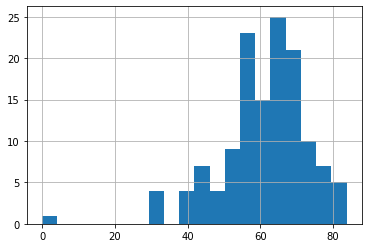

In [22]:
# Looking at a histogram of the ages of the 135 healthy controls we have data on
df_betas.Age.hist(bins=20)
plt.show()

In [24]:
df_betas.to_csv('df_betas.csv')